In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./data/listings.csv')
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

I am going to examine the reviews and prices. As such, I want to clean up the data to account for any data without reviews or prices. I'll make a subset of the data and maintain the original dataframe for the time being.

In [2]:
df_subset = df.copy(deep = True) # create copy
# clean up the erroneous symbols in the data to format the price as a float
df_subset['price'] = df_subset.price.str.replace("$","")
df_subset['price'] = df_subset.price.str.replace(",","").astype(float)
df_subset['rating'] =df['review_scores_rating']
df_subset['avail365'] = df['availability_365']

What is the average price of an Airbnb in Seattle? What does the distribution look like?

Text(0, 0.5, 'Count of Airbnb at price')

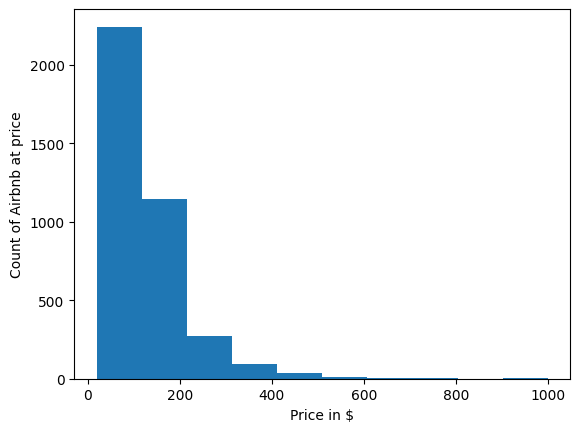

In [3]:

avg_price = df_subset.price.mean()
plt.hist(df_subset.price)
plt.xlabel('Price in $')
plt.ylabel('Count of Airbnb at price')

Are vistors leaving better reviews for more expensive stays?

(array([1.00e+00, 0.00e+00, 4.00e+00, 0.00e+00, 3.00e+00, 1.80e+01,
        2.90e+01, 1.52e+02, 4.54e+02, 2.51e+03]),
 array([ 20.,  28.,  36.,  44.,  52.,  60.,  68.,  76.,  84.,  92., 100.]),
 <BarContainer object of 10 artists>)

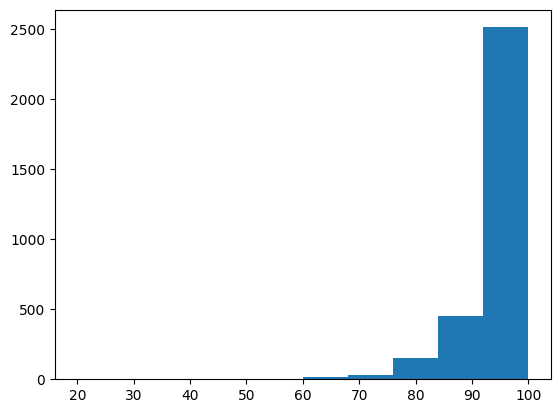

In [4]:
plt.hist(df_subset.rating) # look at distribution of ratings

Text(0, 0.5, 'Rating')

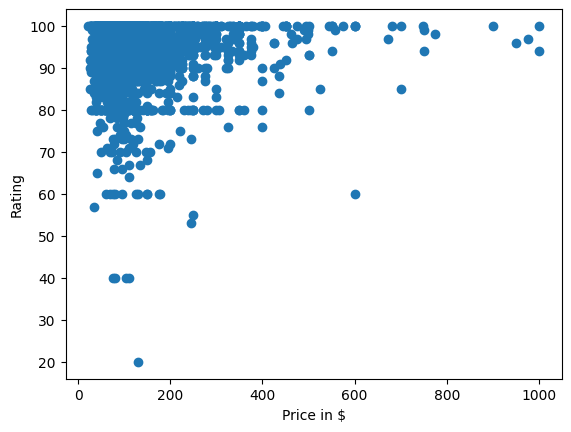

In [5]:
# Plot rankings vs price
plt.scatter(df_subset.price, df_subset.rating)
plt.xlabel('Price in $')
plt.ylabel('Rating')

There are more ratings at lower priced stays, but higher priced stays do have consistently higher ratings. Does the availability show us anything else about the bookings?

Text(0, 0.5, 'Count')

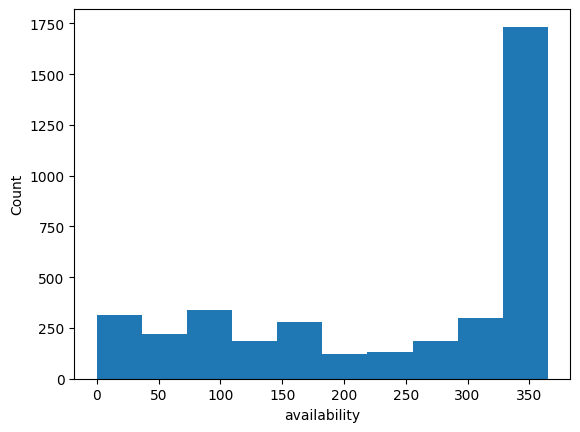

In [6]:
# look at the availability over the next 365 and determine if price influences availability
plt.hist(df_subset.avail365) # this histogram doesn't reveal much other than that there are plenty of Airbnb's with availability!
plt.xlabel('availability')
plt.ylabel('Count')

Text(0.5, 0, 'Price in $')

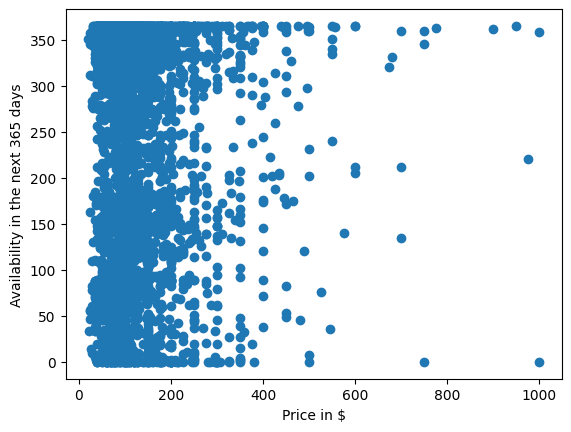

In [7]:
# plot price and availability
plt.scatter(df_subset.price, df_subset.avail365)
plt.ylabel('Availability in the next 365 days')
plt.xlabel('Price in $')

Predict the price of the Airbnb based on the listing data.

In [8]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
'''
    for cat_col in cat_cols:
        try:
            dummies = pd.get_dummies(df[cat_col], dummy_na = dummy_na, drop_first = True, prefix = cat_col, prefix_sep = '_')
            df = df.drop(columns = [cat_col])
            df = df.join(dummies)
        except:
            continue
    return df

In [9]:
def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    # Drop the rows with missing response values
    df = df.dropna(subset = [response_col], axis = 0)
    # Drop columns with NaN for all the values
    df = df.dropna(how = 'all', axis = 1)
    # Use create_dummy_df to dummy categorical columns
    df = create_dummy_df(df, cat_cols, dummy_na)
    # Fill the mean of the column for any missing values Mean function
    fill_mean = lambda col: col.fillna(col.mean())
    # Fill the mean
    df = df.apply(fill_mean, axis=0)
    # Split your data into a X matrix and a response vector y
    y = df[response_col]
    X = df.drop(columns=[response_col], axis = 1)
    # Create training and test sets of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = rand_state)
    # Instantiate a LinearRegression model with normalized data
    lm_model = LinearRegression()
    # Fit your model to the training data
    lm_model.fit(X_train, y_train)
    # Predict the response for the training data and the test data
    y_train_pred = lm_model.predict(X_train)
    y_test_pred = lm_model.predict(X_test)
    # Obtain an rsquared value for both the training and test data
    train_score = r2_score(y_train, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test, df


In [10]:
# clean up price as done before but to main dataframe as update is needed
df['price'] = df.price.str.replace("$","")
df['price'] = df.price.str.replace(",","").astype(float)

In [11]:

# create categorical columns list
cat_cols_lst = list(df.select_dtypes(include = ['object']))
# use function to fit model
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, df = clean_fit_linear_mod(df, 'price', cat_cols_lst, dummy_na=False)

In [12]:
print('train score: ',train_score,' & ' ,'test score: ', test_score)

train score:  0.9999999429117588  &  test score:  0.6441759100701482


The above indicates the model is overfit; it does really well on our subset but falls short in predicting during testing. It's likely that a linear model isn't the best fit here, but we will improve it in the next step.

First- look at the correlation of the coded df

Feature Analysis

In [15]:
# look at rank of the dataset
lm_model.singular_

array([7.62710474e+08, 1.26204978e+08, 1.02209700e+05, ...,
       2.52629118e+00, 2.39355510e+00, 2.86177030e-07])